# RATING PREDICTION OF BESTBUY LAPTOP REVIEWS - EMRE YENER

In [2]:
import pandas as pd ## datayi oku
import re ## texti temizle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer ## tfidf/count hesaplamalari yap (kelime/phrase icin)
import numpy as np ## matrixlerde toplama keyf
from sklearn.cluster import KMeans ## gruplamak istersek
import spacy ## process et (tokenize, pos tag, lemmatize etc)
from nltk import RegexpParser ## kurallara gore phrase extract et
import operator
from collections import Counter
import nltk
from textblob import TextBlob
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, multilabel_confusion_matrix, f1_score
import shap
import matplotlib.pyplot as plt

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])
df = pd.read_csv('C:/Users/emrey/Desktop/final_project/final_results.csv')
#rating_df_1 = df[df['rating'] == 1].reset_index(drop=True).iloc[:1000]
#rating_df_2 = df[df['rating'] == 2].reset_index(drop=True).iloc[:1000]
#rating_df_3 = df[df['rating'] == 3].reset_index(drop=True).iloc[:1000]
#rating_df_4 = df[df['rating'] == 4].reset_index(drop=True).iloc[:1000]
#rating_df_5 = df[df['rating'] == 5].reset_index(drop=True).iloc[:1000]
#df = pd.concat([rating_df_1,rating_df_2,rating_df_3,rating_df_4,rating_df_5],axis = 0).reset_index(drop=True)
df.head()

# Dataframe Cleaning

In [ ]:
df['helpful_clean'] = df['helpful'].apply(lambda x: x.split('. ')[1])
df['unhelpful_clean'] = df['unhelpful'].apply(lambda x: x.split('. ')[1])
df.drop(columns = ['helpful', 'unhelpful'],inplace = True)
df.head()

In [ ]:
df['helpful'] = df.helpful_clean.apply(lambda x: x.split()[0])
df['unhelpful'] = df.unhelpful_clean.apply(lambda x: x.split()[0])

In [ ]:
df.drop(columns = ['helpful_clean', 'unhelpful_clean'],inplace = True)
df.head()

In [ ]:
punc_pattern = r"(\.|\,|\:|\;|\'|\"\-|\=|\\|\<|\>|\?|\)|\(|\*|\&|\^|\%|\$|\#|\@|\!|\~|\`)"
df['cleaned_body'] = df['body'].apply(lambda x: re.sub('\n',' ', re.sub('\r',' ', re.sub(r'\=',' ',x))))
df['dalyarrak deniz'] = df['cleaned_body'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(str(''.join(i for i in x if ord(i)<128))) if len(token.tag_) > 0 and token.tag_[0] in ['N','J','V']]))
df['processed_body'] = df['dalyarrak deniz'].apply(lambda x: re.sub(r'\s{2,}', ' ', re.sub(punc_pattern, ' ', x)).strip())
print(df.body[0])

In [ ]:
df['clean_title'] = df['title'].fillna('').apply(lambda x: re.sub('\n',' ', re.sub('\r',' ', re.sub(r'\=',' ',x))))
df['processed_title'] = df['clean_title'].apply(lambda x: re.sub(r'\s{2,}', ' ', re.sub(punc_pattern, ' ', x)).strip().lower())
df.drop(columns=['cleaned_body','dalyarrak deniz','clean_title'],inplace = True)
df.head()

In [ ]:
df['recommend_flag'] = df['recommend a friend'].apply(lambda x: 1 if x == 'Yes' else 0)
df.drop(columns=['recommend a friend'],inplace = True)
df.head()

In [3]:
#THIS CSV FILE IS THE VERSION WHICH HAS THE TEXT PRE-PROCESSED FOR EFFICIENCY PURPOSES
df = pd.read_csv('C:/Users/emrey/Desktop/final_project/final_df_verbs.csv').fillna('')
df.head()

,Unnamed: 0,product title,title,body,submission date,rating,helpful,unhelpful,processed_body,processed_title,recommend_flag
0,0,"Google - Pixelbook 12.3"" Touchscreen Chromeboo...",ALMOST Perfect. Best Chromebook & its by GOOGLE,Google Pixelbook\r\n\r\nSetup/Testing/Conclusi...,"Dec 2, 2017 4:48 PM",4,117,14,Google Pixelbook Setup Testing Conclusion have...,almost perfect best chromebook its by google,1
1,1,"Google - Pixelbook 12.3"" Touchscreen Chromeboo...",A Chromebook that is finally worthy!!,Google hit the market with its latest addition...,"Dec 4, 2017 1:03 PM",5,17,7,Google hit market late addition note worthy Ch...,a chromebook that is finally worthy,1
2,2,"Google - Pixelbook 12.3"" Touchscreen Chromeboo...","As a Chromebook, it's a go... Convertible... meh.",-=|First Impressions|=-\r\n\r\n|Thoughts|\r\nI...,"Dec 4, 2017 1:01 PM",3,59,13,Impressions| be look be verse ChromeOS have of...,as a chromebook it s a go convertible meh,0
3,3,"Google - Pixelbook 12.3"" Touchscreen Chromeboo...",Likely the best Chromebook available.,"Well to preface, there is a little bit of a le...","Dec 22, 2017 9:58 PM",5,12,1,preface be little bit learning curve be averag...,likely the best chromebook available,1
4,4,"Google - Pixelbook 12.3"" Touchscreen Chromeboo...",Goodbye Windows!,Brief review because review below looks too lo...,"Jan 5, 2019 9:45 AM",5,7,0,brief review review look do want read buy love...,goodbye windows,1


# Helpful/Unhelpful Distribution with Respect to Rating

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000276787D7320>,
      dtype=object)

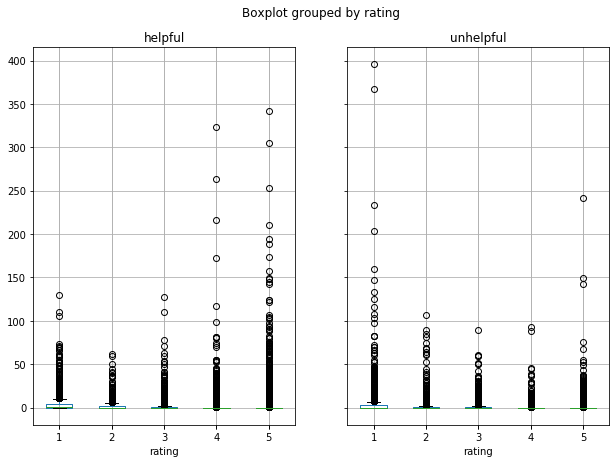

In [4]:
df.boxplot(column=['helpful','unhelpful'], by='rating', figsize=(10,7))

# Recommend a Flag Counts with Respect to Rating

rating
1       47
2       65
3     1192
4    14681
5    57355
Name: recommend_flag, dtype: int64


Text(0, 0.5, 'Count of Reviews')

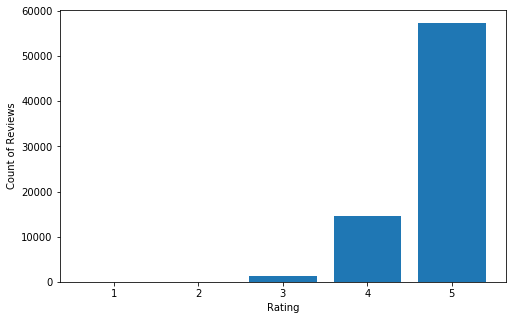

In [5]:
rec_counts = df.groupby('rating').agg('recommend_flag').sum()
print(rec_counts)
fig, ax = plt.subplots(figsize=(8,5))
ax.bar([i for i in range(1,6)], [rec_counts[i] for i in range(1,6)])
ax.set_xlabel('Rating')
ax.set_ylabel('Count of Reviews')

# Checking Processed Review Length to Remove Noise from Training Set

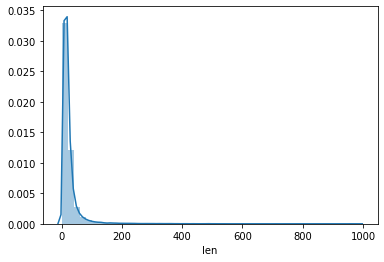

In [6]:
df['all_text'] = df['processed_title'] + ' ' + df['processed_body']
df['len'] = df['all_text'].apply(lambda x: len(x.split()))
df['len'].value_counts

sns.distplot(df['len'])

In [7]:
df = df[(df['len'] >= 8) & (df['len'] <= 100)]

In [8]:
#df['product title new'] = df['product title'].apply(lambda x: re.sub(r'\s{2,}',' ', ' '.join(''.join(i for i in x if ord(i)<128).split('-')[:2])).strip())
#j = df['product title new'].value_counts()
#[a for a in df['product title new'].unique() if j[a] >= 500]
#df.head()

# TF-IDF Vectorizing

In [9]:
tfidf_body = TfidfVectorizer(min_df=10, max_df=0.4, stop_words='english', ngram_range=(1,2))
tfidf_body.fit(df['processed_body'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.4, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [10]:
tfidf_title = TfidfVectorizer(min_df=10, max_df=0.4, stop_words='english', ngram_range=(1,2))
tfidf_title.fit(df['processed_title'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.4, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [11]:
vocab = list(set([k for k in list(tfidf_body.vocabulary_.keys()) + list(tfidf_title.vocabulary_.keys())]))
vocab = {k:i for i,k in enumerate(vocab)}

In [12]:
rating_texts = []
df['all_text'] = df['processed_title'] + ' ' + df['processed_body']
a = df.groupby('rating')
vocabs = []
for group in a.groups:
    print(group)
    current_group = a.get_group(group)
    curr_vect = TfidfVectorizer(min_df=20, max_df=0.6, ngram_range=(1,2))
    curr_vect.fit(current_group['all_text'])
    vocabs.extend(list(curr_vect.vocabulary_.keys()))
    rating_texts.append(' '.join(current_group['all_text'].tolist()))
vocabs = list(set(vocabs))
print(len(vocabs))
print(vocabs)

1
2
3
4
5
8231
['macbook is', 'computer compact', 'customer', 'air retina', 'chance', 'package', 'slick', 'boot up', 'weight make', 'mean be', 'have screen', 'pro first', 'good light', 'be satisfied', 'vibrant', 'buy get', 'be 4th', 'fast boot', 'personal', 'laptop have', 'secondary', 'premium', 'list', 'be pleased', 'printing', 'useful', 'school', 'sleek fast', 'reliable easy', 'be surprised', 'use simple', 'quick do', 'fast buy', 'title', 'product make', 'mac is', 'great in', 'track', 'music production', 'pro use', 'screen speed', 'assume', 'have pro', 'son school', 'dell laptop', 'perfect choice', 'itunes', 'high quality', 'looking', 'hope last', 'use like', 'high resolution', 'love sync', 'light macbook', 'state drive', 'anti virus', 'screen other', 'macbook light', 'something light', 'thumb', 'homework be', 'size computer', 'light powerful', 'laptop lenovo', 'be go', 'day battery', 'opportunity', 'computer but', 'want computer', 'get computer', 'needs laptop', 'confusing', 'price 

In [13]:
rating_tfidf = TfidfVectorizer(min_df = 1, max_df = 3, ngram_range=(1,2))
rating_tfidf.fit(rating_texts)
len(rating_tfidf.vocabulary_)

335331

In [14]:
filtered_vocab = [word for word in rating_tfidf.vocabulary_.keys() if word in vocabs]
filtered_vocab = {word:i for i,word in enumerate(filtered_vocab)}

In [15]:
len(filtered_vocab)

2890

In [16]:
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df['all_text'] = shuffled_df['processed_title'] + ' ' + shuffled_df['processed_body']
shuffled_df = shuffled_df[(shuffled_df['rating'] == 1) | (shuffled_df['rating'] == 5)].reset_index(drop = True)
shuffled_df['adj_rating'] = shuffled_df['rating'].apply(lambda x: 1 if x == 5 else 0)
labels = pd.get_dummies(shuffled_df['adj_rating']).reset_index(drop=True)

# Grid Search

In [ ]:
grid_vect = CountVectorizer(ngram_range = (1,2),binary = True, vocabulary = vocab)
x = grid_vect.fit_transform(shuffled_df['all_text']).toarray()
x = np.append(x,shuffled_df[['recommend_flag','helpful','unhelpful']].values, axis=1)
grid_search = GridSearchCV(estimator = DecisionTreeClassifier(), 
                          param_grid = {'max_depth':[4,6,8,10,12],
                                       'max_leaf_nodes':[25,50,100,None],
                                       'max_features':[100,200,500,None],
                                       'min_samples_leaf':[1,5,10,20,30]},
                          cv = 5,
                          n_jobs = -1,
                          verbose = True,
                          scoring = 'roc_auc')

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

# Decision Tree

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3)
for train_idx, test_idx in sss.split(shuffled_df['all_text'], shuffled_df['adj_rating']):
    count_all_text = CountVectorizer(ngram_range = (1,2),binary = True, vocabulary = filtered_vocab)
    train_y = shuffled_df['adj_rating'].iloc[train_idx]#labels[[1,2,3,4,5]].iloc[train_idx]
    test_y = shuffled_df['adj_rating'].iloc[test_idx]#labels[[1,2,3,4,5]].iloc[test_idx]
    train_x = count_all_text.fit_transform(shuffled_df['all_text'].iloc[train_idx]).toarray()
    test_x = count_all_text.transform(shuffled_df['all_text'].iloc[test_idx]).toarray()
    train_x = np.append(train_x, shuffled_df[['recommend_flag','helpful','unhelpful']].iloc[train_idx].values, axis=1)
    test_x = np.append(test_x, shuffled_df[['recommend_flag','helpful','unhelpful']].iloc[test_idx].values, axis=1)
    model = DecisionTreeClassifier(max_features=None, max_leaf_nodes=25, min_samples_leaf=10)
    model.fit(train_x,train_y)
    test_preds = model.predict(test_x)
    test_probs = [e[1] for e in model.predict_proba(test_x)]
    #print(confusion_matrix(test_y, test_preds))
    print('\n\n')
    print('Confusion Matrix: ')
    print(confusion_matrix(test_y, test_preds))
    print('ROC AUC Score :', roc_auc_score(test_y, test_probs))
    print('Precision Score: ', precision_score(test_y, test_preds))
    print('Recall Score: ', recall_score(test_y, test_preds))
    print('F1 Score: ', f1_score(test_y, test_preds))

In [ ]:
cols = list(count_all_text.vocabulary_.keys()) + ['recommend_flag','helpful','unhelpful']

In [ ]:
imps = model.feature_importances_
for k,v in sorted([(cols[i],imps[i]) for i in range(len(cols))], key=operator.itemgetter(1), reverse=True):
    if v > 0:
        print(k,v)

# Logistic Regression

In [17]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3)
for train_idx, test_idx in sss.split(shuffled_df['all_text'], shuffled_df['adj_rating']):
    count_all_text = CountVectorizer(ngram_range = (1,2),binary = True, vocabulary = filtered_vocab)
    train_y = shuffled_df['adj_rating'].iloc[train_idx]#labels[[1,2,3,4,5]].iloc[train_idx]
    test_y = shuffled_df['adj_rating'].iloc[test_idx]#labels[[1,2,3,4,5]].iloc[test_idx]
    train_x = count_all_text.fit_transform(shuffled_df['all_text'].iloc[train_idx]).toarray()
    test_x = count_all_text.transform(shuffled_df['all_text'].iloc[test_idx]).toarray()
    train_x = np.append(train_x, shuffled_df[['recommend_flag','helpful','unhelpful']].iloc[train_idx].values, axis=1)
    test_x = np.append(test_x, shuffled_df[['recommend_flag','helpful','unhelpful']].iloc[test_idx].values, axis=1)

In [18]:
log_model = LogisticRegression(penalty='l1', tol=0.0001, C=1.0, 
                               class_weight='balanced', solver='liblinear', max_iter=100, 
                               verbose=1, n_jobs=-1)
log_model.fit(train_x, train_y)
test_preds_log = log_model.predict(test_x)
test_probs = [e[1] for e in log_model.predict_proba(test_x)]
test_probs_full = log_model.predict_proba(test_x)
print('\n\n')
print('Confusion Matrix: ')
print(confusion_matrix(test_y, test_preds_log))
print('ROC AUC Score :', roc_auc_score(test_y, test_probs))
print('Precision Score: ', precision_score(test_y, test_preds_log))
print('Recall Score: ', recall_score(test_y, test_preds_log))
print('F1 Score: ', f1_score(test_y, test_preds_log))

c:\users\emrey\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]


Confusion Matrix: 
[[  568     9]
 [   94 15845]]
ROC AUC Score : 0.9955236074970836
Precision Score:  0.9994323199192633
Recall Score:  0.9941025158416463
F1 Score:  0.99676029314629


# Further Analysis

In [34]:
feat_imps = dict(zip(list(filtered_vocab.keys()) + ['recommend_flag','helpful','unhelpful'] , list(log_model.coef_[0]) ))

{'graduate': 0.0,
 'omg': 0.0,
 'tie': 0.0,
 'crystal': 0.0,
 'lady': 0.0,
 'rig': 0.0,
 'request': 0.0,
 'fourth': 0.0,
 'practice': 0.0,
 'fool': 0.0,
 'teacher': 0.0,
 'rave': 0.0,
 'purposes': -2.1383941139647087,
 'her': 0.0,
 'com': 0.0,
 'workflow': 0.0,
 'advance': 0.0,
 'perfectly': 0.0,
 'im': 0.0,
 'heart': 0.0,
 'longevity': 0.0,
 'anybody': 0.0,
 'meeting': 0.0,
 'thanks': 0.0,
 'medical': 0.0,
 'complaints': 0.0,
 'garage': 0.0,
 'pocket': 0.0,
 'into': 0.0,
 'fiance': 0.0,
 '2012': 0.0,
 'ultimate': 0.3193124331798922,
 'animation': 0.0,
 'finally': 0.0,
 'powerhouse': 0.0,
 'surpass': 0.0,
 'east': 0.0,
 'airs': 0.0,
 'collection': 0.0,
 'champ': 0.0,
 'stability': 0.0,
 'winner': 0.0,
 'absolutely': 2.071186428000804,
 'event': 0.0,
 'customize': 0.0,
 'sooo': 0.0,
 'geforce': 0.0,
 'craft': 0.0,
 'nurse': 0.0,
 'palm': 0.0,
 'lb': 0.0,
 'wifes': 0.0,
 'rocks': -1.7284499805919766,
 'church': 0.0,
 'citizen': 0.0,
 'mba': 0.0,
 'tutorial': 0.0,
 'beneficial': 0.0,
 'sl

In [25]:
test_df = shuffled_df.iloc[test_idx]
test_df['probs'] = test_probs
test_df['preds'] = test_preds_log
test_df['pred_flag'] = (test_df['preds'] == test_df['adj_rating']).astype(int)
test_df = test_df[test_df['pred_flag'] == 1]
pos_test_df = test_df[test_df['adj_rating'] == 1].reset_index(drop=True)
neg_test_df = test_df[test_df['adj_rating'] == 0].reset_index(drop=True)
neg_test_df.head()

c:\users\emrey\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\emrey\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\emrey\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be s

,Unnamed: 0,product title,title,body,submission date,rating,helpful,unhelpful,processed_body,processed_title,recommend_flag,all_text,len,adj_rating,probs,preds,pred_flag
0,34924,"HP - Stream 11.6"" Laptop - Intel Celeron - 4GB...",Maybe good for young kids,Bought it for ease and simplicity but it would...,"Jun 29, 2019 7:51 AM",1,0,0,buy ease simplicity stay connected WiFi geek s...,maybe good for young kids,0,maybe good for young kids buy ease simplicity ...,27,0,0.005625,0,1
1,24559,"Dell - G7 15.6"" Gaming Laptop - Intel Core i7-...",Bad cooling system,"The first couple of days I use this laptop, th...","Sep 16, 2019 10:31 AM",1,10,3,first couple day use laptop computer get hot p...,bad cooling system,0,bad cooling system first couple day use laptop...,52,0,0.002710,0,1
2,73567,"Apple - MacBook Air® - 13.3"" Display - Intel ...",blackout screen & not turning on after 1 yr 5 ...,you brand new laptop will be safe only 1 year ...,"Mar 5, 2019 9:30 PM",1,1,1,brand new laptop be safe year day pay have pay...,blackout screen not turning on after 1 yr 5 days,0,blackout screen not turning on after 1 yr 5 da...,28,0,0.003927,0,1
3,14172,"HP - EliteBook 14"" Refurbished Laptop - Intel ...",The battery of the laptop gets consume very fast,Computer is a little slow and the battery gets...,"May 12, 2017 8:31 PM",1,0,0,computer be little slow battery get consume,the battery of the laptop gets consume very fast,0,the battery of the laptop gets consume very fa...,16,0,0.005625,0,1
4,281,"HP - Pavilion x360 2-in-1 11.6"" Touch-Screen L...",Horrible! Would not recommend for college stud...,I bought this laptop February of 2018 and from...,"Aug 28, 2019 1:01 AM",1,5,6,buy laptop February moment open box be slow lo...,horrible would not recommend for college students,0,horrible would not recommend for college stude...,82,0,0.000616,0,1


In [27]:
filtered_vocab_idx = {v:k for k,v in filtered_vocab.items()}
pos_test_df['phrases'] = pos_test_df['all_text'].apply(lambda x:[filtered_vocab_idx[i] for i in count_all_text.fit_transform([x]).nonzero()[1]])
neg_test_df['phrases'] = neg_test_df['all_text'].apply(lambda x:[filtered_vocab_idx[i] for i in count_all_text.fit_transform([x]).nonzero()[1]])

In [38]:
pos_phrases = Counter([p for ps in pos_test_df.phrases.tolist() for p in ps])
neg_phrases = Counter([p for ps in neg_test_df.phrases.tolist() for p in ps])
pos_phrases = sorted([(k,v * feat_imps[k]) for k,v in pos_phrases.items()], key = operator.itemgetter(1) , reverse = True)
neg_phrases = sorted([(k,v * feat_imps[k] * -1) for k,v in neg_phrases.items()], key = operator.itemgetter(1) , reverse = True)

In [41]:
pos_phrases[:100]

[('excellent laptop', 1277.6884128059476),
 ('for school', 656.3895131634195),
 ('perfect laptop', 533.2865671436766),
 ('perfect for', 513.6699442530914),
 ('excellent computer', 389.7813460450133),
 ('awesome laptop', 339.50045515529223),
 ('computer easy', 333.15398164239986),
 ('easy navigate', 298.84672587621657),
 ('product easy', 230.13255808536485),
 ('loves', 173.03347665025507),
 ('and fast', 166.75484226235525),
 ('fast and', 143.52745619748976),
 ('fast easy', 139.13478389744964),
 ('college love', 121.1817898430677),
 ('all around', 119.71586970709882),
 ('retina', 116.119448161115),
 ('first macbook', 98.09778894706494),
 ('wife love', 91.83325757615377),
 ('lightweight easy', 82.26361419841855),
 ('fast good', 79.59073003091541),
 ('learn use', 75.50085005445528),
 ('school love', 72.97156939639376),
 ('great tablet', 70.19101761869196),
 ('awesome be', 66.93327557502627),
 ('gold', 58.73698689302811),
 ('son love', 55.18934997481661),
 ('absolutely', 49.7084742720193),
 ('excellent for', 48.56864160643604),
 ('be search', 47.07281835971908),
 ('work perfect', 46.020260952654695),
 ('breeze', 43.3152848516553),
 ('great macbook', 41.46652085676377),
 ('best computer', 40.3927377342527),
 ('glad do', 38.567365910779365),
 ('excellent product', 36.84974537841546),
 ('computer to', 30.91242530531388),
 ('macbook love', 30.640143165049256),
 ('great all', 30.110700625209642),
 ('upgrade year', 26.37003967209585),
 ('just what', 26.004626160462177),
 ('it love', 25.252641685942635),
 ('light keyboard', 22.734419713030558),
 ('quick start', 22.390698296880103),
 ('easy setup', 21.99466913786278),
 ('pleased purchase', 21.01338590401449),
 ('college year', 20.488571646809596),
 ('tablet great', 20.023036888435072),
 ('weight easy', 18.275196256272366),
 ('have iphone', 18.001332682358647),
 ('fast reliable', 17.19740178023379),
 ('laptop perfect', 16.995518536122123),
 ('camera for', 16.072553288022362),
 ('macbook last', 15.654448200734961),
 ('simple use', 15.294320424476389),
 ('great lap', 14.295034501322174),
 ('use lightweight', 13.504434087220535),
 ('laptop excellent', 12.706811393546113),
 ('college fall', 12.378826522774963),
 ('love easy', 11.976781276863784),
 ('amazing computer', 11.238650347362652),
 ('have want', 10.217798045847264),
 ('love work', 10.032784153529043),
 ('easy travel', 9.791274746413212),
 ('terrific', 9.621713473969603),
 ('get college', 9.394762748650647),
 ('have worry', 8.072637381308049),
 ('my new', 7.95703658500919),
 ('amazing light', 7.6035039210908595),
 ('great everyday', 7.204130148748587),
 ('new feature', 7.032903699234293),
 ('be unique', 6.944866248716904),
 ('mac love', 6.899033274278678),
 ('clear screen', 6.825215080769429),
 ('really like', 6.800251336492553),
 ('perfect college', 6.504247997392103),
 ('flexibility', 6.4140836638277525),
 ('new toy', 5.904374677346098),
 ('need upgrade', 5.655284696814963),
 ('more use', 5.387392349181001),
 ('great recommend', 5.371920776982785),
 ('for great', 5.307914741674901),
 ('fast speed', 5.144223171211709),
 ('far so', 5.098164366623812),
 ('gift love', 4.679855859640681),
 ('dream', 4.4425447521756345),
 ('ultimate', 3.5124367649788146),
 ('purchase gift', 3.4608164739958673),
 ('daughter high', 3.4058967518367917),
 ('anyone need', 2.9845113036183863),
 ('perfect computer', 1.687631511433133),
 ('1st laptop', 1.5839739889602509),
 ('the way', 1.5013654582291052),
 ('graduation present', 1.364569507645703),
 ('gripe', 1.1343675845916672),
 ('love speed', 0.986922903022228),
 ('fast start', 0.7347574215488636),
 ('spreadsheet', 0.4734977413566777),
 ('great school', 0.03991079117756076),
 ('to have', 0.0),
 ('week love', 0.0)]

In [39]:
neg_phrases[:20]

[('not buy', 12.857319514917798),
 ('be show', 4.934148958363895),
 ('be 1st', 4.499854932990403),
 ('don buy', 4.3017256136786575),
 ('go window', 1.9591472057134551),
 ('application have', -0.0),
 ('charge laptop', -0.0),
 ('have throw', -0.0),
 ('get touch', -0.0),
 ('work iphone', -0.0),
 ('mac year', -0.0),
 ('go best', -0.0),
 ('office use', -0.0),
 ('navigate have', -0.0),
 ('fourth', -0.0),
 ('be fourth', -0.0),
 ('fast user', -0.0),
 ('helpful be', -0.0),
 ('be steal', -0.0),
 ('go mac', -0.0)]

# Shap: Sample Specific Feature Impact Visualization

In [ ]:
explainer = shap.LinearExplainer(log_model, train_x, feature_dependence="independent")
shap_values = explainer.shap_values(test_x)
X_test_array = test_x
shap.summary_plot(shap_values, X_test_array, feature_names=cols)

In [ ]:
for i,val in sorted([(cols[i], log_model.coef_[0][i]) for i in range(len(cols)) if log_model.coef_[0][i]>0], key=operator.itemgetter(1), reverse=True):
    print(i,val)

In [ ]:
test_df = shuffled_df.iloc[test_idx].reset_index(drop=True)
test_df['PRED'] = test_preds_log
false_pos = test_df[(test_df['adj_rating'] == 0) & (test_df['PRED'] == 1)]
false_pos_x = count_all_text.transform(false_pos['all_text']).toarray()
false_pos_x = np.append(false_pos_x, false_pos[['recommend_flag','helpful','unhelpful']].values, axis=1)
false_pos_x = pd.DataFrame(false_pos_x, columns=cols)

In [ ]:
shap.initjs()
explainer = shap.LinearExplainer(log_model, train_x, feature_dependence="independent")
shap_values = explainer.shap_values(false_pos_x)
shap.force_plot(explainer.expected_value, shap_values[0], false_pos_x.iloc[0])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[1], false_pos_x.iloc[1])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[2], false_pos_x.iloc[2])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[3], false_pos_x.iloc[3])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[4], false_pos_x.iloc[4])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[5], false_pos_x.iloc[5])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[6], false_pos_x.iloc[6])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[7], false_pos_x.iloc[7])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[8], false_pos_x.iloc[8])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[9], false_pos_x.iloc[9])

In [ ]:
false_neg = test_df[(test_df['adj_rating'] == 1) & (test_df['PRED'] == 0)]
false_neg_x = count_all_text.transform(false_neg['all_text']).toarray()
false_neg_x = np.append(false_neg_x, false_neg[['recommend_flag','helpful','unhelpful']].values, axis=1)
false_neg_x = pd.DataFrame(false_neg_x, columns=cols)
shap_values = explainer.shap_values(false_neg_x)
false_neg_x.shape

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0], false_neg_x.iloc[0])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[1], false_neg_x.iloc[1])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[2], false_neg_x.iloc[2])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[3], false_neg_x.iloc[3])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[4], false_neg_x.iloc[4])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[5], false_neg_x.iloc[5])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[6], false_neg_x.iloc[6])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[7], false_neg_x.iloc[7])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[8], false_neg_x.iloc[8])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[9], false_neg_x.iloc[9])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[10], false_neg_x.iloc[10])

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)

#shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], x_1.iloc[0])


In [ ]:
shap_values = explainer.shap_values()

shap.force_plot(explainer.expected_value[0], shap_values[0][102,:], x_1.iloc[102])

In [ ]:
shap.summary_plot(shap_values=shap_values, features=test_x, feature_names=cols)